In [1]:
%%capture
%pip install ir_datasets
%pip install demoji
%pip install pycld3
%pip install langdetect

import re
import numpy as np
import pandas as pd
import ir_datasets
import demoji

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

from langdetect import detect
from cld3 import get_language

from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from tqdm.notebook import tqdm

from collections import Counter

from utils import *

pd.set_option('max_colwidth', 800)

In [2]:
# load dataset
dataset = ir_datasets.load("cord19/trec-covid")
print(f"queries: {dataset.queries_count()}, docs: {dataset.docs_count()}, qrels: {dataset.qrels_count()}")

queries: 50, docs: 192509, qrels: 69318


In [3]:
%%capture
# convert the collection in a dataframe
queries = pd.DataFrame(dataset.queries_iter())
docs = pd.DataFrame(dataset.docs_iter())
qrels = pd.DataFrame(dataset.qrels_iter())

docs['date'] = pd.to_datetime(docs['date'])

# Part 1: Analysis of Queries and Documents

In [ ]:
display(queries.sample(5))
display(docs.sample(5))
display(qrels.sample(5))

## Analysis of Documents

### Filter Covid documents

Visualize years distribution

/home/saiteki-kai/プロジェクト/進行中/ir-covid/venv/lib/python3.8/site-packages/pandas/core/series.py:5258: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.
  self._update_inplace(result)


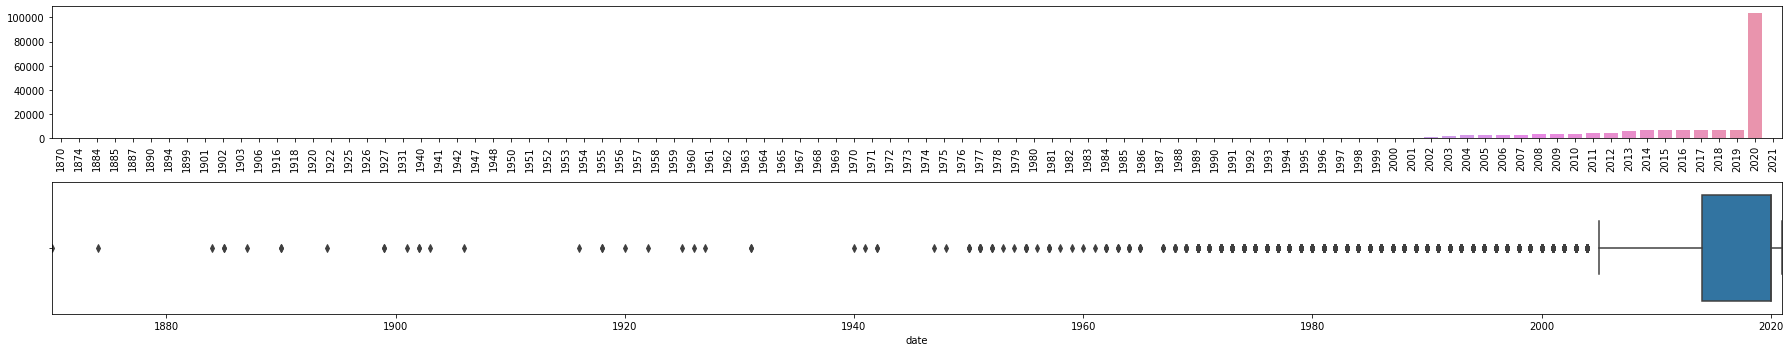

In [18]:
years = docs["date"].dt.year
years.dropna(inplace=True)
years = years.astype(int)

u_years, u_counts = np.unique(years, return_counts=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 5))

sns.barplot(x=u_years, y=u_counts, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

sns.boxplot(x=years, ax=ax2, orient="h")
ax2.margins(0)

fig.tight_layout()

In [4]:
keywords = [
    "covid 19",
    "covid-19",
    "covid19",
    "sars-cov-2",
    "sarscov2",
    "sars cov 2",
    "2019-nCoV",
    "Wuhan virus",
    "Chinese flu",
    "COronaVIrusDisease",
]

keep = set()
for index, row in tqdm(docs.iterrows(), total=len(docs)):
    text = " ".join([row["title"], row["abstract"]])
    if any(re.findall(r"|".join(keywords), text, re.IGNORECASE)):
        keep.add(index)

    # the few documents without date contain at least one keyword
    if row["date"] and row["date"] is not pd.NaT:
        if row["date"].year >= 2019:
            if any(
                re.findall(
                    r"coronavirus | corona",
                    " ".join([row["title"], row["abstract"]]),
                    re.IGNORECASE,
                )
            ):
                keep.add(index)

print(f"{len(keep)}, {round(len(keep) / len(docs) * 100)}%")

docs = docs.iloc[list(keep)]

  0%|          | 0/192509 [00:00<?, ?it/s]

84377, 44%


In [5]:
len(docs)

84377

### Missing Values

In [6]:
docs.replace("", pd.NA, inplace=True)

for col in docs:
  m = sum(docs[col].isna())
  p = m / len(docs) * 100
  print(f"{col:10} {m:5} ({p:.2f}%)")

doc_id         0 (0.00%)
title          4 (0.00%)
doi        40929 (48.51%)
date          17 (0.02%)
abstract   34097 (40.41%)


In [7]:
docs[docs['title'].isna()]

,doc_id,title,doi,date,abstract
29824,3palbki5,<NA>,10.31053/1853.0605.v77.n2.28336,2020-04-29,La enfermedad por coronavirus (COVID-19) se ha expandido mundialmente y convertido en un problema prioritario de salud a nivel mundial. Se presenta el caso de un paciente con COVID-19 y se describen las características radiológicas más relevantes.
36596,j633bvoz,<NA>,10.31053/1853.0605.v77.n1.28066,2020-03-31,"Este artículo analiza la cobertura mediática del avance de la pandemia de Covid-19 en Argentina y la medida de aislamiento social preventivo y obligatorio decretada por el gobierno nacional. Destaca tendencias problemáticas y buenas prácticas según un enfoque teórico-normativo, y las vincula con las características históricas del sistema de medios en el país. Utiliza una perspectiva teórico-metodológica que concibe a la comunicación como un derecho humano fundamental, esencial en una sociedad democrática y a los medios de comunicación de masas como vehículo fundamental para su ejercicio, y se apoya en las recomendaciones formuladas por organismos internacionales, organizaciones de la sociedad civil e instituciones nacionales. Se sostiene que los medios de comunicación de masas en la Ar..."
38854,vsypmeqd,<NA>,10.31053/1853.0605.v77.n1.28031,2020-03-31,"El impacto que ha originado la enfermedad por coronavirus 2019 (COVID-19) en diferentes partes del mundo, alcanza en la actualidad 597, 072 personas contagiadas y 27,364 fallecidas según los últimos reportes. En ese contexto, en nuestro país, una zona de relevancia epidemiológica es la amazonia peruana, debido a la distribución de enfermedades endémicas como las enfermedades metaxénicas (Dengue, Malaria entre otras), en donde el problema se incrementa debido a que la infección por COVID-19 puede llevar a falsos positivos en las pruebas de cribado para Dengue. Conllevando de esa forma a un retraso en el diagnóstico de la infección por COVID-19 y una mayor diseminación del virus, debido a que en la mayor parte de los casos de Dengue no se presentan signos de alarma y el tratamiento es am..."
50912,6zjdj8w7,<NA>,10.1055/a-1149-3625,2020-04-01,"Die WHO hat am 11.03.20 die Verbreitung des SARS-CoV-2 als weltweite Pandemie eingestuft 1. Eine hohe Basisreproduktionszahl ermöglicht in einer globalisierten Welt die schnelle Verbreitung des Virus. Die Basisreproduktionszahl liegt bei SARS-CoV-2 bei 2–3.3, d. h. dass jede infizierte Person 2–3.3 weitere Personen infizieren wird, sofern keine Schutzmaßnahmen ergriffen werden 2. Diese Basisreproduktionszahl liegt höher als bei der klassischen Influenza und ist bei COVID-19, der durch das SARS-CoV-2 verursachten Lungenerkrankung, gekoppelt mit einer substanziellen Zahl an schweren Verläufen, die eine stationäre oder intensivmedizinisch-stationäre Betreuung der Patienten erfordern 3. Auch weisen erste Daten darauf hin, dass die Zahl an Langzeitbeatmungen unter den beatmungspflichtigen P..."


In [8]:
docs[docs['abstract'].isna()].sample(5)

,doc_id,title,doi,date,abstract
90382,ss4oazl5,"Aprendiendo en casa durante la pandemia del Covid-19, una iniciativa de estudiantes de latinoamerica./ Aprendiendo en casa durante la pandemia del Covid-19, una iniciativa de estudiantes de latinoamerica./ [Learning at home during the COVID-19 pandemic: An initiative of Latin American students]",<NA>,2020-01-01,<NA>
175311,duttw9xn,Early application of prone position for management of Covid-19 patients,10.1016/j.jclinane.2020.109917,2020-05-26,<NA>
116046,o3ngfggx,"Lopinavir/ritonavir in COVID-19 patients: maybe yes, but at what dose?",<NA>,2020-01-01,<NA>
148739,x3lip4s2,COVID-19 and SIC (!),10.1016/j.jvs.2020.05.047,2020-06-01,<NA>
115145,gisqo0sp,Amplification of human ß-glucuronidase gene for appraising the accuracy of negative SARS-CoV-2 RT-PCR results in upper respiratory tract specimens,<NA>,2020-01-01,<NA>


### Duplicated Values

In [9]:
duplicated = sum(docs.duplicated())
duplicated_perc = duplicated / len(docs) * 100
print(f"duplicated rows: {duplicated}, {duplicated_perc:.2f}%")

duplicated rows: 182, 0.22%


In [10]:
def print_duplicates(docs, columns=None):
  if columns is None:
    columns = docs.columns

  for col in columns:
    d = sum(docs[~docs[col].isna()][col].duplicated())
    p = d / len(docs) * 100
    print(f"{col:10} {d:5} ({p:.2f}%)")

In [11]:
print("Duplicates for each column:")
print_duplicates(docs, columns=["doc_id", "title", "doi", "abstract"])

Duplicates for each column:
doc_id      1218 (1.44%)
title      23279 (27.59%)
doi         1196 (1.42%)
abstract   10969 (13.00%)


In [12]:
docs[docs["doc_id"] == "uym826bh"]

,doc_id,title,doi,date,abstract
29885,uym826bh,First Case of Covid-19 in the United States.,10.1056/nejmc2004794,2020-04-22,<NA>
34884,uym826bh,First Case of Covid-19 in the United States. Reply.,10.1056/nejmc2004794,2020-04-22,<NA>
39326,uym826bh,First Case of Covid-19 in the United States.,10.1056/nejmc2004794,2020-04-22,<NA>
48825,uym826bh,First Case of Covid-19 in the United States.,10.1056/nejmc2004794,2020-04-22,<NA>
50121,uym826bh,First Case of Covid-19 in the United States.,10.1056/nejmc2004794,2020-04-22,<NA>
58677,uym826bh,First Case of Covid-19 in the United States.,10.1056/nejmc2004794,2020-04-22,<NA>


In [13]:
docs.drop_duplicates(inplace=True)
docs[docs["doc_id"] == "uym826bh"]

,doc_id,title,doi,date,abstract
29885,uym826bh,First Case of Covid-19 in the United States.,10.1056/nejmc2004794,2020-04-22,<NA>
34884,uym826bh,First Case of Covid-19 in the United States. Reply.,10.1056/nejmc2004794,2020-04-22,<NA>


In [14]:
print_duplicates(docs, columns=["doc_id", "title", "doi", "abstract"])

doc_id      1036 (1.23%)
title      23097 (27.43%)
doi         1018 (1.21%)
abstract   10885 (12.93%)


In [15]:
duplicated = sum(docs.duplicated(["title", "abstract"]))
print(f"Duplicates (title, abstract): {duplicated} ({duplicated / len(docs) * 100:.2f}%)")

duplicated = sum(docs.duplicated(["doc_id", "title", "abstract"]))
print(f"Duplicates (doc_id, title, abstract): {duplicated} ({duplicated / len(docs) * 100:.2f}%)")

duplicated = sum(docs.duplicated(["doc_id", "title", "abstract", "doi"]))
print(f"Duplicates (doc_id, title, abstract, doi): {duplicated} ({duplicated / len(docs) * 100:.2f}%)")

Duplicates (title, abstract): 17971 (21.34%)
Duplicates (doc_id, title, abstract): 198 (0.24%)
Duplicates (doc_id, title, abstract, doi): 196 (0.23%)


Example of the same document with different dates

In [16]:
docs[docs['doc_id'] == "0fbmelx0"]

,doc_id,title,doi,date,abstract
31860,0fbmelx0,Changes in population movement make COVID-19 spread differently from SARS.,10.1016/j.socscimed.2020.113036,2020-05-15,"This comment discusses the contribution of population movement to the spread of COVID-19, with a reference to the spread of SARS 17 years ago. We argue that the changing geography of migration, the diversification of jobs taken by migrants, the rapid growth of tourism and business trips, and the longer distance taken by people for family reunion are what make the spread of COVID-19 so differently from that of SARS. These changes in population movement are expected to continue. Hence, new strategies in disease prevention and control should be taken accordingly, which are also proposed in the comment."
47330,0fbmelx0,Changes in population movement make COVID-19 spread differently from SARS.,10.1016/j.socscimed.2020.113036,2020-06-01,"This comment discusses the contribution of population movement to the spread of COVID-19, with a reference to the spread of SARS 17 years ago. We argue that the changing geography of migration, the diversification of jobs taken by migrants, the rapid growth of tourism and business trips, and the longer distance taken by people for family reunion are what make the spread of COVID-19 so differently from that of SARS. These changes in population movement are expected to continue. Hence, new strategies in disease prevention and control should be taken accordingly, which are also proposed in the comment."
141240,0fbmelx0,Changes in population movement make COVID-19 spread differently from SARS,10.1016/j.socscimed.2020.113036,2020-05-15,"This comment discusses the contribution of population movement to the spread of COVID-19, with a reference to the spread of SARS 17 years ago. We argue that the changing geography of migration, the diversification of jobs taken by migrants, the rapid growth of tourism and business trips, and the longer distance taken by people for family reunion are what make the spread of COVID-19 so differently from that of SARS. These changes in population movement are expected to continue. Hence, new strategies in disease prevention and control should be taken accordingly, which are also proposed in the comment."


### Detect Languages
https://modelpredict.com/language-identification-survey

In [36]:
# download the pretrained model for fasttext language identification
import requests
pretrained_model = "https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin"

results = requests.get(pretrained_model)
with open('/tmp/lid.176.bin', 'wb') as f:
    f.write(results.content)

In [37]:
from lang_identification import LanguageIdentification
lang_id = LanguageIdentification()

languages = []
for i, doc in tqdm(docs.iterrows(), total=len(docs)):
    text = doc['abstract']

    if text is pd.NA or text == "":
        text = doc['title']
    try:                                                          
        # lang = detect(text)        # language_detect  
        # lang = get_language(text)  # cld3 
        # lang = lang.language  
        lang = lang_id.predict_lang(text)                         
    except Exception as e:                                                
        lang='unknown'
    languages.append(lang)

languages = np.asarray(languages)
v, c = np.unique(languages, return_counts=True)

  0%|          | 0/84195 [00:00<?, ?it/s]

In [38]:
Counter(languages).most_common(20)

[('en', 81823),
 ('es', 1020),
 ('fr', 526),
 ('de', 426),
 ('pt', 133),
 ('zh', 72),
 ('nl', 51),
 ('it', 45),
 ('no', 39),
 ('ja', 17),
 ('da', 14),
 ('pl', 6),
 ('tr', 4),
 ('ru', 3),
 ('la', 3),
 ('sv', 2),
 ('sl', 2),
 ('ur', 2),
 ('ceb', 1),
 ('ca', 1)]

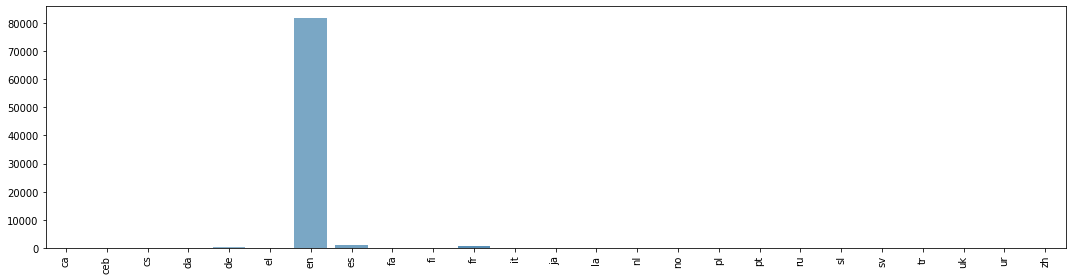

In [67]:
fig = plt.figure(figsize=(15, 4))
sns.barplot(x=v, y=c, palette="Blues_d")
fig.axes[0].set_xticklabels(fig.axes[0].get_xticklabels(), rotation=90)
fig.tight_layout()
fig.savefig("out/languages.png")

In [41]:
print(len(docs.loc[languages == "en"]))
en_docs = docs.loc[languages == "en"]

81823


In [42]:
print(len(docs.loc[languages != "en"]))
not_en_docs = docs.loc[languages != "en"]

2372


### Find Emojis

In [ ]:
emojis = []
for index, row in tqdm(docs.iterrows(), total=len(docs)):
    e1 = demoji.findall(row["title"])
    if e1:
      emojis.extend(list(e1.keys()))

    e2 = demoji.findall(row["abstract"])
    if e2:
      emojis.extend(list(e2.keys()))

Counter(emojis)

  0%|          | 0/83869 [00:00<?, ?it/s]

Counter({'®': 287, '™': 73, '♦': 3, '©': 86, '⬇': 1, '▪': 7})

## Preprocessing

Apply the preprocess on the documents and the queries

In [43]:
docs = en_docs  # test only english docs
# docs = not_en_docs

In [44]:
# global lists of tokens for wordclouds
titles = []
abstracts = []

docs_preprocessed = docs.copy()
for index, row in tqdm(docs.iterrows(), total=len(docs)):
    if row["title"] is not pd.NA:
      title_tokens = preprocess(row["title"])
      docs_preprocessed.loc[index, "title"] = " ".join(title_tokens)
      titles.extend(title_tokens)

    if row["abstract"] is not pd.NA:
      abstract_tokens = preprocess(row["abstract"])
      docs_preprocessed.loc[index, "abstract"] = " ".join(abstract_tokens)
      abstracts.extend(abstract_tokens)

# docs_preprocessed.to_pickle("data/docs_processed.pkl")
docs_preprocessed.to_pickle("data/en_docs_processed.pkl")

  0%|          | 0/81823 [00:00<?, ?it/s]

In [37]:
queries_preprocessed = queries.copy()
for index, row in tqdm(queries.iterrows(), total=len(queries)):
    queries_preprocessed.loc[index, "title"] = " ".join(preprocess(row["title"]))
    queries_preprocessed.loc[index, "description"] = " ".join(
        preprocess(row["description"])
    )
    queries_preprocessed.loc[index, "narrative"] = " ".join(
        preprocess(row["narrative"])
    )

queries_preprocessed.to_pickle("data/queries_processed.pkl")

  0%|          | 0/50 [00:00<?, ?it/s]

## Word Cloud

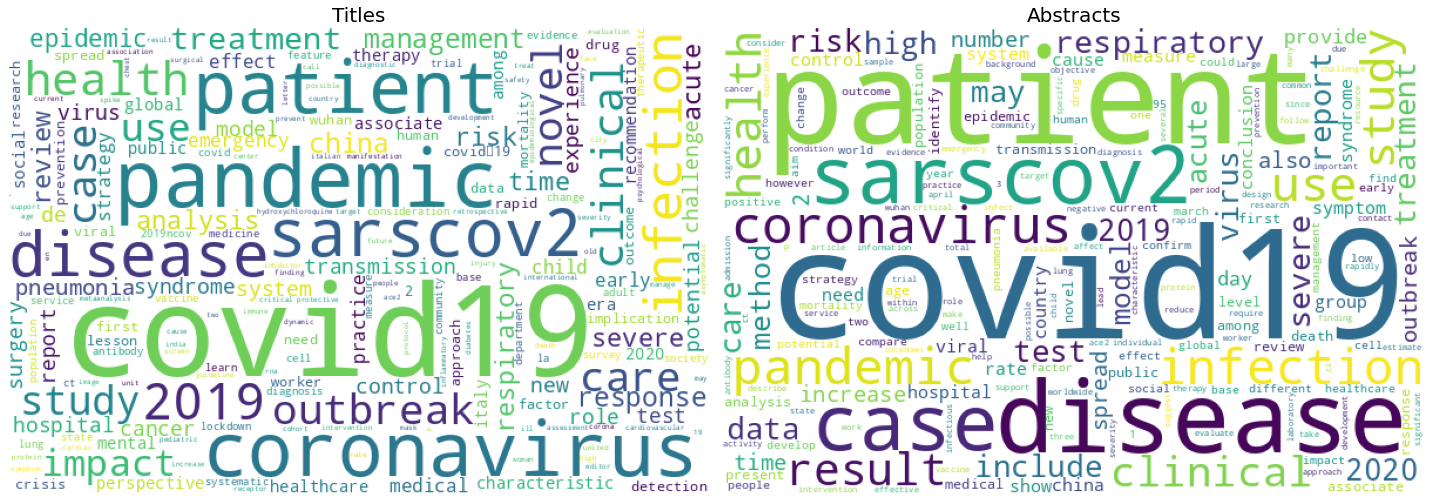

In [45]:
counter_title = Counter(titles)
counter_abstract = Counter(abstracts)

wc1 = WordCloud(collocations=False, background_color="white", width=600, height=400)
wc2 = WordCloud(collocations=False, background_color="white", width=600, height=400)

wc_titles = wc1.fit_words(counter_title)
wc_abstracts = wc2.fit_words(counter_abstract)

wc_titles.to_file("out/wc_titles.png")
wc_abstracts.to_file("out/wc_abstracts.png")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

ax1.imshow(wc_titles)
ax1.set_title("Titles", fontsize=20)
ax1.axis("off")

ax2.imshow(wc_abstracts)
ax2.set_title("Abstracts", fontsize=20)
ax2.axis("off")

fig.tight_layout()

## Token Statistics

In [46]:
print("\n[Number of Tokens]")
print("Titles:", len(counter_title.keys()))
print("Abstracts:", len(counter_abstract.keys()))

k = 10
top_k_titles = [word for word, _ in counter_title.most_common(k)]
top_k_abstracts = [word for word, _ in counter_abstract.most_common(k)]

print(f"\n[Top {k} Most Common Tokens]")
print(f"Titles: {', '.join(top_k_titles)}")
print(f"Abstracts: {', '.join(top_k_abstracts)}")


[Number of Tokens]
Titles: 27331
Abstracts: 106371

[Top 10 Most Common Tokens]
Titles: covid19, pandemic, coronavirus, patient, sarscov2, disease, infection, 2019, health, clinical
Abstracts: covid19, patient, disease, sarscov2, case, coronavirus, pandemic, infection, use, study


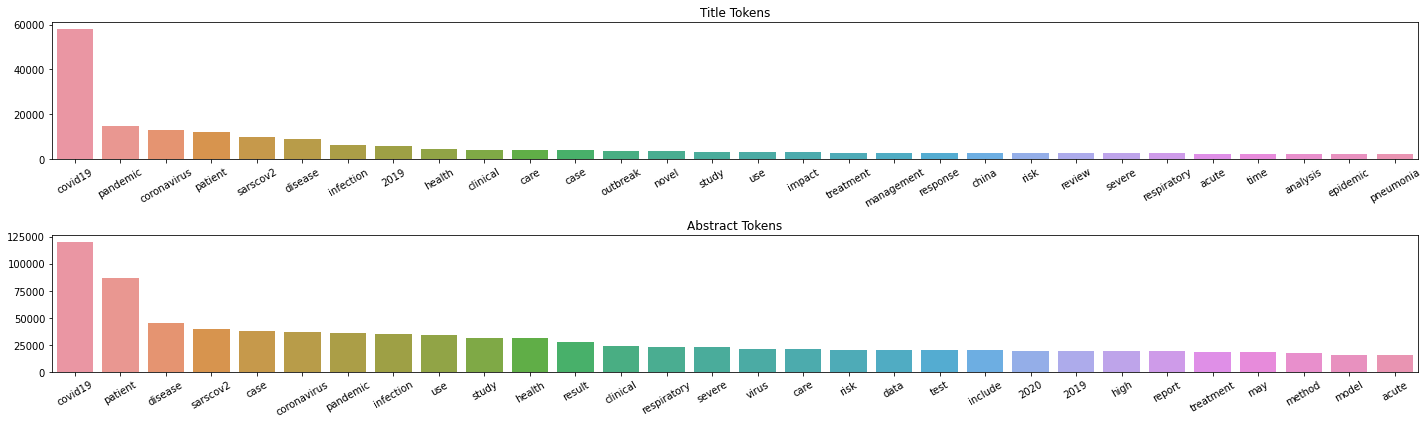

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

k = 30

common_titles = dict(counter_title.most_common(k))
x_title = list(common_titles.keys())
y_title = list(common_titles.values())

common_abstracts = dict(counter_abstract.most_common(k))
x_abstract = list(common_abstracts.keys())
y_abstract = list(common_abstracts.values())

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6))
sns.barplot(x=x_title, y=y_title, ax=ax1)
sns.barplot(x=x_abstract, y=y_abstract, ax=ax2)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30)
ax1.set_title("Title Tokens")
ax2.set_title("Abstract Tokens")
fig.tight_layout()

fig.savefig("out/most_common_en.png")

# Part 2: Basic Search

## Preprocessing of the query
Eliminate stopwords, remove punctuation. 
You can also perform any other pre-processing step.


* Lowcase
* Remove punctuation
* Remove extra whitespaces
* Normalize covid words
* Stop words
* Lemmatization
* Remove HTML tags
* Remove URLs
* Remove emojis



In [ ]:
test_query_old = [
    "CoVid",
    "covid    19",
    "covid-19  influenza",
    "covid, influenza",
    "a covid flue is going on",
    "-term1 +term2",
    "{term1 term2}",
    "term1^2.3",
    "title:term1",
    "+title:term1",
    "title:(term1 term2)^2.3",
    "term1 -title:term2",
    '"term1 term2"',
    '+"term1 term2"',
    '"term1 term2"~n',
]

check_query_old = [
    "covid19",
    "covid19",
    "covid19 influenza",
    "covid19 influenza",
    "covid19 flue go",
    "-term1 +term2",
    "{ term1 term2 }",
    "term1^2.3",
    "title : term1",
    "+title : term1",
    "title : ( term1 term2 ) ^2.3",
    "term1 -title : term2",
    '" term1 term2 "',
    '+ " term1 term2 "',
    '" term1 term2 " ~n',
]


In [ ]:
test_query = [
    "CoVid",
    "covid    19",
    "covid-19  influenza",
    "covid, influenza",
    "a covid flue is going on",
    "-term1 +term2",
    "{term1 term2}",
    "term1^2.3",
    "title:term1",
    "+title:term1",
    "title:(term1 term2)^2.3",
    "term1 -title:term2",
    '"term1 term2"',
    '+"term1 term2"',
    '"term1 term2"~n',
]

check_query = [
    "covid",
    "covid 19",
    "covid-19 influenza",
    "covid influenza",
    "covid flue go",
    "-term1 +term2",
    "{ term1 term2 }",
    "term1^2.3",
    "title : term1",
    "+title : term1",
    "title : ( term1 term2 ) ^2.3",
    "term1 -title : term2",
    '" term1 term2 "',
    '+ " term1 term2 "',
    '" term1 term2 " ~n',
]


In [ ]:
preprocessed_query = []
for query in test_query_old:
    p = " ".join(preprocess(query, covid_normalization=False))
    preprocessed_query.append(p)
print(preprocessed_query)

['covid', 'covid 19', 'covid19 influenza', 'covid influenza', 'covid flue go', 'term1 term2', 'term1 term2', 'term123', 'titleterm1', 'titleterm1', 'titleterm1 term223', 'term1 titleterm2', 'term1 term2', 'term1 term2', 'term1 term2n']


In [ ]:
assert check_query == preprocessed_query

In [ ]:
preprocessed_query_old = []
for query in test_query_old:
    p = " ".join(preprocess(query, covid_normalization=False))
    preprocessed_query_old.append(p)
print(preprocessed_query_old)

['covid', 'covid 19', 'covid19 influenza', 'covid influenza', 'covid flue go', 'term1 term2', 'term1 term2', 'term123', 'titleterm1', 'titleterm1', 'titleterm1 term223', 'term1 titleterm2', 'term1 term2', 'term1 term2', 'term1 term2n']


In [ ]:
assert check_query_old == preprocessed_query_old

## Index the documents

Use PyTerrier to index the documents.

You can choose freely the indexing configurations.
You can index either the document’s titles, abstract, or both.

### Libraries

In [ ]:
%%capture
%pip install python-terrier

import pyterrier as pt
import pandas as pd
import numpy as np

### Data

In [ ]:
docs_preprocessed = pd.read_pickle("data/docs_processed.pkl")

In [ ]:
empty_titles = docs_preprocessed["title"] == ""

print(
    "The dataset has {} rows of ID empty".format(
        len(docs_preprocessed[docs_preprocessed["doc_id"] == ""])
    )
)
print(
    "The dataset has {} rows of TITLE empty".format(
        len(docs_preprocessed[empty_titles])
    )
)
print(
    "The dataset has {} rows of DATE empty".format(
        len(docs_preprocessed[docs_preprocessed["date"].isnull()])
    )
)
print(
    "The dataset has {} rows of ABSTRACT empty".format(
        len(docs_preprocessed[docs_preprocessed["abstract"] == ""])
    )
)
print(
    "The dataset has {} rows of DOI empty".format(
        len(docs_preprocessed[docs_preprocessed["doi"] == ""])
    )
)

print("\ndocs with empty title: " + ", ".join(docs_preprocessed[empty_titles]["doc_id"]))

The dataset has 0 rows of ID empty
The dataset has 8 rows of TITLE empty
The dataset has 17 rows of DATE empty
The dataset has 34043 rows of ABSTRACT empty
The dataset has 40903 rows of DOI empty

docs with empty title: 3palbki5, j633bvoz, vsypmeqd, 6zjdj8w7, o01w28gb, wu00wdlp, idhr2upe, npt8i9bc


In [ ]:
docs_preprocessed["title"].replace({"": "Vuoto"}, inplace=True)
docs_preprocessed["abstract"].replace({"": "Vuoto"}, inplace=True)
docs_preprocessed["doi"].replace({"": "Vuoto"}, inplace=True)
docs_preprocessed["date"].fillna(pd.Timestamp(0, unit="s"), inplace=True)

In [ ]:
print("The dataset has {} rows of ID empty".format(len(docs_preprocessed[docs_preprocessed["doc_id"] == ""])))
print(
    "The dataset has {} rows of TITLE empty".format(
        len(docs_preprocessed[docs_preprocessed["title"] == ""])
    )
)
print(
    "The dataset has {} rows of DATE empty".format(
        len(docs_preprocessed[docs_preprocessed["date"].isnull()])
    )
)
print(
    "The dataset has {} rows of ABSTRACT empty".format(
        len(docs_preprocessed[docs_preprocessed["abstract"] == ""])
    )
)
print("The dataset has {} rows of DOI empty".format(len(docs_preprocessed[docs_preprocessed["doi"] == ""])))

The dataset has 0 rows of ID empty
The dataset has 8 rows of TITLE empty
The dataset has 0 rows of DATE empty
The dataset has 34037 rows of ABSTRACT empty
The dataset has 40891 rows of DOI empty


In [ ]:
np.where(pd.isnull(docs_preprocessed))

(array([12513, 14168, 14869, 15062, 17133, 20827, 21281, 27190, 36260,
        36303, 36676, 38316, 41072, 48113, 49111, 51114, 57137]),
 array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]))

In [ ]:
num_id = [str(i) for i in range(1, len(docs_preprocessed.index) + 1)]
# print(num_id)
docs_preprocessed.insert(0, "docno", num_id, True)

### Index

In [ ]:
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-1.11.0-openjdk-amd64/"

if not pt.started():
    pt.init()

terrier-assemblies 5.6 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.6 jar not found, downloading to /root/.pyterrier...
Done
PyTerrier 0.7.2 has loaded Terrier 5.6 (built by craigmacdonald on 2021-09-17 13:27)


In [ ]:
def create_index(docs_df, mode="both", indexer_path="./pd_index"):

    #num_id = [str(i) for i in range(1, len(docs_df.index) + 1)]
    # print(num_id)
    #docs_df.insert(0, "docno", num_id, True)

    docs_df.rename(columns={'doc_id':'docno'}, inplace=True)

    pd_indexer = pt.DFIndexer(indexer_path, remove_stopwords=False, overwrite=True)

    if mode == "title":
        index_ref = pd_indexer.index(docs_df["title"], docs_df["docno"])
    elif mode == "abstract":
        index_ref = pd_indexer.index(docs_df["abstract"], docs_df["docno"])
    else:  # both or else
        index_ref = pd_indexer.index(
            docs_df["title"], docs_df["abstract"], docs_df["docno"]
        )

    return index_ref


In [ ]:
# docs_preprocessed['title'].replace("", pd.NA, inplace=True)
# docs_preprocessed['abstract'].replace("", pd.NA, inplace=True)
# docs_preprocessed['doi'].replace("", pd.NA, inplace=True)
# docs_preprocessed['doc_id'].replace("", pd.NA, inplace=True)
# docs_preprocessed.info()

In [ ]:
docs_preprocessed.rename(columns={'doc_id':'docno'}, inplace=True)
pd_indexer = pt.DFIndexer("./index", remove_stopwords=False, overwrite=True)
pd_indexer.index(docs_preprocessed["title"], docs_preprocessed["docno"])

18:01:41.078 [main] WARN org.terrier.structures.indexing.Indexer - Adding an empty document to the index (3palbki5) - further warnings are suppressed
18:02:27.703 [main] WARN org.terrier.structures.indexing.Indexer - Indexed 14 empty documents
18:02:27.892 [main] ERROR org.terrier.structures.indexing.Indexer - Could not finish MetaIndexBuilder: 
java.io.IOException: Key jquazfc8 is not unique: 35598,5061
For MetaIndex, to suppress, set metaindex.compressed.reverse.allow.duplicates=true
	at org.terrier.structures.collections.FSOrderedMapFile$MultiFSOMapWriter.mergeTwo(FSOrderedMapFile.java:1374)
	at org.terrier.structures.collections.FSOrderedMapFile$MultiFSOMapWriter.close(FSOrderedMapFile.java:1308)
	at org.terrier.structures.indexing.BaseMetaIndexBuilder.close(BaseMetaIndexBuilder.java:321)
	at org.terrier.structures.indexing.classical.BasicIndexer.createDirectIndex(BasicIndexer.java:346)
	at org.terrier.structures.indexing.Indexer.index(Indexer.java:369)


<org.terrier.querying.IndexRef at 0x7ff71317e350 jclass=org/terrier/querying/IndexRef jself=<LocalRef obj=0x563b2510cd90 at 0x7ff711f395d0>>

In [ ]:
# index the text, record the docnos as metadata
index_ref = create_index(docs_preprocessed, mode="both")

13:34:14.232 [main] WARN org.terrier.structures.indexing.Indexer - Adding an empty document to the index (1804) - further warnings are suppressed
13:35:03.135 [main] WARN org.terrier.structures.indexing.Indexer - Indexed 14 empty documents


In [ ]:
!ls -lh pd_index/

合計 35M
-rw-rw-r-- 1 saiteki-kai saiteki-kai 1.5M  1月 14 13:35 data.direct.bf
-rw-rw-r-- 1 saiteki-kai saiteki-kai 2.1M  1月 14 13:35 data.document.fsarrayfile
-rw-rw-r-- 1 saiteki-kai saiteki-kai 1.3M  1月 14 13:35 data.inverted.bf
-rw-rw-r-- 1 saiteki-kai saiteki-kai 2.2M  1月 14 13:35 data.lexicon.fsomapfile
-rw-rw-r-- 1 saiteki-kai saiteki-kai 1017  1月 14 13:35 data.lexicon.fsomaphash
-rw-rw-r-- 1 saiteki-kai saiteki-kai  93K  1月 14 13:35 data.lexicon.fsomapid
-rw-rw-r-- 1 saiteki-kai saiteki-kai 1.7M  1月 14 13:35 data.meta-0.fsomapfile
-rw-rw-r-- 1 saiteki-kai saiteki-kai 567K  1月 14 11:04 data.meta-0.fsomapfile.0
-rw-rw-r-- 1 saiteki-kai saiteki-kai 227K  1月 14 11:04 data.meta-0.fsomapfile.1
-rw-rw-r-- 1 saiteki-kai saiteki-kai 657K  1月 14 13:35 data.meta.idx
-rw-rw-r-- 1 saiteki-kai saiteki-kai  25M  1月 14 13:35 data.meta.zdata
-rw-rw-r-- 1 saiteki-kai saiteki-kai 4.4K  1月 14 13:35 data.properties
-rw-rw-r-- 1 saiteki-kai saiteki-kai    0  1月 14 10:10 data_stream0_1.direct.bf
-rw-rw

In [ ]:
index = pt.IndexFactory.of(index_ref)

In [ ]:
print(index.getCollectionStatistics().toString())

i = 0
max = 10
for kv in index.getLexicon():
    i = i + 1
    if i < max:
        print("%s -> %s" % (kv.getKey(), kv.getValue().toString()))
    if i == max:
        print(".....")
        break


Number of documents: 84048
Number of terms: 23779
Number of postings: 730918
Number of fields: 2
Number of tokens: 755236
Field names: [title, abstract]
Positions:   false

0 -> term19326 Nt=5 TF=5 maxTF=1 @{0 0 0} TFf=0,0
000 -> term3877 Nt=27 TF=27 maxTF=1 @{0 13 0} TFf=0,0
002 -> term9282 Nt=4 TF=4 maxTF=1 @{0 83 0} TFf=0,0
016 -> term9986 Nt=1 TF=1 maxTF=1 @{0 95 2} TFf=0,0
019 -> term11918 Nt=1 TF=1 maxTF=1 @{0 99 0} TFf=0,0
025 -> term17930 Nt=2 TF=2 maxTF=1 @{0 102 6} TFf=0,0
03 -> term1335 Nt=4 TF=4 maxTF=1 @{0 111 0} TFf=0,0
0354 -> term23229 Nt=1 TF=1 maxTF=1 @{0 121 4} TFf=0,0
05 -> term1342 Nt=4 TF=4 maxTF=1 @{0 126 0} TFf=0,0
.....


In [ ]:
def index_model(index, model="TF_IDF"):
    """
    Create and return an indexing model.
    http://terrier.org/docs/current/javadoc/org/terrier/matching/models/package-summary.html
    Model can be such as:
    "TF_IDF", "PL2", "DLH",
    "Hiemstra_LM", "Dirichlet_LM",
    "BM25", etc
    """
    list_model = ["TF_IDF", "PL2", "DLH", "Hiemstra_LM", "Dirichlet_LM", "BM25"]

    indexing_model = pt.BatchRetrieve(index, wmodel=model)
    return indexing_model

In [ ]:
model = index_model(index, model="TF_IDF")

https://github.com/terrier-org/terrier-core/blob/5.x/doc/querylanguage.md

In [ ]:
# A single query (that I manually provide)
retr = model.search("introduction modern climate change")
display(retr.head(10))

docids = retr[retr["rank"] < 5]["docid"]
for id in docids:
  print("[" + str(id) + "] TITLE: " + docs_preprocessed.iloc[id]["title"])
  print("[" + str(id) + "] ABSTRACT: " + docs_preprocessed.iloc[id]["abstract"][:100] + "...")

,qid,docid,docno,rank,score,query
0,1,2123,2124,0,16.758584,introduction modern climate change
1,1,2610,2611,1,16.758584,introduction modern climate change
2,1,7679,7680,2,16.758584,introduction modern climate change
3,1,7734,7735,3,16.758584,introduction modern climate change
4,1,9940,9941,4,16.758584,introduction modern climate change
5,1,16546,16547,5,16.758584,introduction modern climate change
6,1,16547,16548,6,16.758584,introduction modern climate change
7,1,33966,33967,7,10.531068,introduction modern climate change
8,1,54850,54851,8,10.531068,introduction modern climate change
9,1,58723,58724,9,10.531068,introduction modern climate change


[2123] TITLE: introduction modern climate change andrew e dessler cambridge university press 2011 252 pp isbn10 0521173159
[2123] ABSTRACT: climate change variability climate system include atmosphere biogeochemical cycle carbon cycle nitro...
[2610] TITLE: introduction modern climate change andrew e dessler cambridge university press 2011 252 pp isbn10 0521173159
[2610] ABSTRACT: climate change variability climate system include atmosphere biogeochemical cycle carbon cycle nitro...
[7679] TITLE: introduction modern climate change andrew e dessler cambridge university press 2011 252 pp isbn10 0521173159
[7679] ABSTRACT: climate change variability climate system include atmosphere biogeochemical cycle carbon cycle nitro...
[7734] TITLE: introduction modern climate change andrew e dessler cambridge university press 2011 252 pp isbn10 0521173159
[7734] ABSTRACT: climate change variability climate system include atmosphere biogeochemical cycle carbon cycle nitro...
[9940] TITLE: introducti

In [ ]:
print("+woman covid")
retr = model.search("+woman covid")
print(len(retr.index))
display(retr.head(3))

print("+woman covid")
retr = model.search("+woman covid")
print(len(retr.index))
display(retr.head(3))

print("+woman +covid")
retr = model.search("+woman +covid")
print(len(retr.index))
display(retr.head(3))

print("+woman +covid")
retr = model.search("+woman +covid")
print(len(retr.index))
display(retr.head(3))

print("-woman +covid")
retr = model.search("-woman +covid")
print(len(retr.index))
display(retr.head(3))

print("-woman +covid")
retr = model.search("-woman +covid")
print(len(retr.index))
display(retr.head(3))

print("{woman covid}")
retr = model.search("{woman covid}")
print(len(retr.index))
display(retr.head(3))

print("{ woman term2 }")
retr = model.search("{ woman covid }")
print(len(retr.index))
display(retr.head(3))


+woman covid
620


,qid,docid,docno,rank,score,query
0,1,76668,76669,0,7.489326,+woman covid
1,1,81751,81752,1,7.489326,+woman covid
2,1,68732,68733,2,6.807841,+woman covid


+woman covid
620


,qid,docid,docno,rank,score,query
0,1,76668,76669,0,7.489326,+woman covid
1,1,81751,81752,1,7.489326,+woman covid
2,1,68732,68733,2,6.807841,+woman covid


+woman +covid
15


,qid,docid,docno,rank,score,query
0,1,76668,76669,0,7.489326,+woman +covid
1,1,81751,81752,1,7.489326,+woman +covid
2,1,68732,68733,2,6.807841,+woman +covid


+woman +covid
15


,qid,docid,docno,rank,score,query
0,1,76668,76669,0,7.489326,+woman +covid
1,1,81751,81752,1,7.489326,+woman +covid
2,1,68732,68733,2,6.807841,+woman +covid


-woman +covid
1000


,qid,docid,docno,rank,score,query
0,1,107,108,0,4.315667,-woman +covid
1,1,2078,2079,1,4.315667,-woman +covid
2,1,3440,3441,2,4.315667,-woman +covid


-woman +covid
1000


,qid,docid,docno,rank,score,query
0,1,107,108,0,4.315667,-woman +covid
1,1,2078,2079,1,4.315667,-woman +covid
2,1,3440,3441,2,4.315667,-woman +covid


{woman covid}
1000


,qid,docid,docno,rank,score,query
0,1,107,108,0,4.018384,{woman covid}
1,1,2078,2079,1,4.018384,{woman covid}
2,1,3440,3441,2,4.018384,{woman covid}


{ woman term2 }
1000


,qid,docid,docno,rank,score,query
0,1,107,108,0,4.018384,{ woman covid }
1,1,2078,2079,1,4.018384,{ woman covid }
2,1,3440,3441,2,4.018384,{ woman covid }


To do indexing just choose the model to use through the function:

`index_ref = create_index(docs_df, mode="both")`

mode decide if indexing just title, abstract or both.

`index = pt.IndexFactory.of(index_ref)`

`tfidf = index_model(index, model="TF_IDF")`

and then use the function:

`tfidf.search("your query")`


To know more about the query look [here](https://github.com/terrier-org/terrier-core/blob/5.x/doc/querylanguage.md)

To know more about the model you can use look [here](http://terrier.org/docs/current/javadoc/org/terrier/matching/models/package-summary.html). You can use model as "TF_IDF", "PL2", "DLH", "Hiemstra_LM", "Dirichlet_LM", etc.


# Part 3: Advanced Search (Optional)

# NOTE

prof: importate la precision. l'obiettivo é riportare la risposta migliore
